In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]


In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader 
import numpy as np
import h5py
import matplotlib.pyplot as plt

class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = np.array(self.dataset[str(index)+'.jpg'])
        # 128x128 사각형으로 크롭
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(3,128,128) / 255.0
    
    def plot_image(self, index):
        img = np.array(self.dataset[str(index)+'.jpg'])
        # 128x128 사각형으로 크롭
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    

In [ ]:
import torch
import torch.nn as nn

class View(nn.Module):
    def __init__(self,shape):
        super().__init__()
        self.shape = shape,
    def forward(self,x):
        return x.view(*self.shape)

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self,dim_latent=200):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        self.dim_latent = dim_latent
       # 신경망 레이어 정의
        self.encoder = nn.Sequential(
            # (1,3,128,128) 형태를 의도
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,32,64,64)
            
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,64,32,32)

            nn.Conv2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,64,16,16)
            
            nn.Conv2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,64,8,8)

            View((-1,64*8*8)),
            nn.Linear(64*8*8, 2*self.dim_latent),
        )
        
        self.decoder = nn.Sequential(
            #(200)
            nn.Linear(self.dim_latent,64*8*8),
            View((-1,64,8,8)),
            #(64,8,8)

            nn.ConvTranspose2d(64,64,2,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),            
            #(64,16,16)

            nn.ConvTranspose2d(64,64,2,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(64,32,32)

            nn.ConvTranspose2d(64,32,2,stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(32,64,64)

            nn.ConvTranspose2d(32,3,2,stride=2),
            nn.Sigmoid()
            #(3,128,128)
        )

        # 손실 함수 생성
        self.loss_function = nn.BCELoss()

        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0005)
    def forward(self,x):
        x = self.encoder(x)
        x = x.view(-1,2,self.dim_latent)

        self.mu = x[:,0,:]
        self.log_var = x[:,1,:]

        epsilon = torch.randn_like(self.mu)
        sigma = torch.exp(self.log_var/2)

        self.z = self.mu+sigma*epsilon
        de = self.decoder(self.z)
        return de

    def train(self,data_loader):
        kl_loss_wight=10000
        for epoch in range(1, 101):
            for x_input in data_loader:
                self.optimiser.zero_grad()
                y_pred = self.forward(x_input)
                
                mse_loss = ((y_pred- x_input)**2).sum()
                kl_loss = -0.5*torch.sum(1+self.log_var-2*self.mu**2 - 2*torch.exp(self.log_var))
                loss = mse_loss+kl_loss*kl_loss_wight
                loss.backward()
                self.optimiser.step()
            if epoch % 1 == 0:
                print(f"Epoch {epoch}: loss = {loss.item()} mse loss= {mse_loss:.2f} kl loss={kl_loss*kl_loss_wight:.2f}")


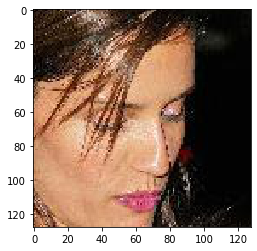

In [ ]:
dataset = CelebADataset('mount/My Drive/Colab Notebooks/firstGAN/celeba_dataset/celeba_aligned_small.h5py')
dataset.plot_image(3)
dataloader = DataLoader(dataset,32,True,generator=torch.Generator(device='cuda'))


<All keys matched successfully>

In [ ]:
%%time 

model = ConvVAE()
model.train(dataloader)

Epoch 1: loss = 23004438.0
Epoch 2: loss = 22682124.0
Epoch 3: loss = 22561990.0
Epoch 4: loss = 22469370.0
Epoch 5: loss = 22384896.0
Epoch 6: loss = 22372876.0
Epoch 7: loss = 22373566.0
Epoch 8: loss = 22329804.0
Epoch 9: loss = 22308418.0
Epoch 10: loss = 22347688.0
Epoch 11: loss = 22310124.0
Epoch 12: loss = 22315890.0
Epoch 13: loss = 22303310.0
Epoch 14: loss = 22293212.0
Epoch 15: loss = 22289170.0
Epoch 16: loss = 22301010.0
Epoch 17: loss = 22296156.0
Epoch 18: loss = 22307060.0
Epoch 19: loss = 22282150.0
Epoch 20: loss = 22294886.0
Epoch 21: loss = 22297286.0
Epoch 22: loss = 22278480.0
Epoch 23: loss = 22288462.0
Epoch 24: loss = 22278822.0
Epoch 25: loss = 22288710.0
Epoch 26: loss = 22270536.0
Epoch 27: loss = 22287900.0
Epoch 28: loss = 22285762.0
Epoch 29: loss = 22269066.0
Epoch 30: loss = 22269900.0
Epoch 31: loss = 22281794.0
Epoch 32: loss = 22283676.0
Epoch 33: loss = 22286460.0
Epoch 34: loss = 22292638.0
Epoch 35: loss = 22280620.0
Epoch 36: loss = 22285796.0
E

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_vae_celeb_trained.pth")

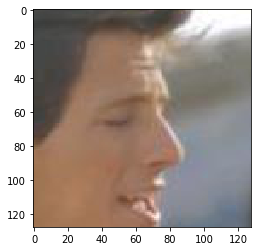

In [ ]:
img = np.array(dataset.dataset[str(2)+'.jpg'])
# 128x128 사각형으로 크롭
img = crop_centre(img, 128, 128)
plt.imshow(img, interpolation='nearest')
#torch.cuda.FloatTensor(img).permute(2,0,1).view(3,128,128) / 255.0

torch.Size([1, 3, 128, 128])
torch.Size([2, 3, 128, 128])
torch.Size([3, 3, 128, 128])
torch.Size([4, 3, 128, 128])
torch.Size([5, 3, 128, 128])
torch.Size([6, 3, 128, 128])
torch.Size([7, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([9, 3, 128, 128])
torch.Size([10, 3, 128, 128])


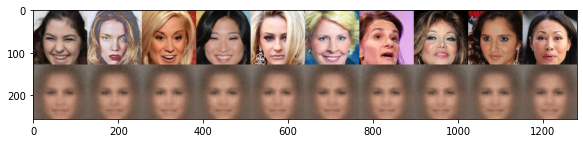

In [ ]:
import matplotlib.pyplot as plt

def compare(model, n_samples = 10):
    file_object = h5py.File('mount/My Drive/Colab Notebooks/firstGAN/celeba_dataset/celeba_aligned_small.h5py', 'r')
    dataset = file_object['img_align_celeba']
    indices = np.random.choice(20000, n_samples)
    x_input_con=None
    for index in indices:
        img = np.array(dataset[str(index)+'.jpg'])
        img = crop_centre(img, 128, 128)
        x_input = torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
        if x_input_con==None:
            x_input_con=x_input
        else:
            x_input_con = torch.concatenate([x_input_con,x_input])
        print(x_input_con.shape)
    y_pre = model.forward(x_input_con).detach().cpu().numpy()
    y_samples = y_pre.reshape(-1,3,128, 128).transpose((2, 0, 3,1)).reshape(128, 128 * n_samples,3)
    x_samples = x_input_con.detach().cpu().numpy().reshape(-1,3, 128, 128).transpose((2, 0, 3,1)).reshape(128, 128 * n_samples,3)

    plt.figure(figsize=(16, 2))
    plt.imshow(np.concatenate([x_samples, y_samples]))

compare(model, 10)

In [ ]:
model = ConvVAE()
model.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/my_vae_celeb_trained.pth"))

<All keys matched successfully>

In [ ]:
%%time 

model.train(dataloader)

Epoch 1: loss = 22290524.0 mse loss= 98122.83 kl loss=22192402.00
Epoch 2: loss = 22283906.0 mse loss= 98396.95 kl loss=22185510.00
Epoch 3: loss = 22278218.0 mse loss= 95267.33 kl loss=22182950.00
Epoch 4: loss = 22281160.0 mse loss= 98074.40 kl loss=22183086.00
Epoch 5: loss = 22280966.0 mse loss= 98554.90 kl loss=22182412.00
Epoch 6: loss = 22273808.0 mse loss= 91923.28 kl loss=22181884.00
Epoch 7: loss = 22280282.0 mse loss= 98153.17 kl loss=22182128.00
Epoch 8: loss = 22272330.0 mse loss= 90446.14 kl loss=22181884.00
Epoch 9: loss = 22279870.0 mse loss= 98541.70 kl loss=22181328.00
Epoch 10: loss = 22274806.0 mse loss= 93533.25 kl loss=22181272.00
Epoch 11: loss = 22286396.0 mse loss= 105091.20 kl loss=22181304.00
Epoch 12: loss = 22272536.0 mse loss= 91181.86 kl loss=22181354.00
Epoch 13: loss = 22272502.0 mse loss= 91043.30 kl loss=22181458.00
Epoch 14: loss = 22275462.0 mse loss= 94412.74 kl loss=22181050.00
Epoch 15: loss = 22264466.0 mse loss= 83318.35 kl loss=22181148.00
Epo

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_vae_celeb_trained2.pth")

torch.Size([1, 3, 128, 128])
torch.Size([2, 3, 128, 128])
torch.Size([3, 3, 128, 128])
torch.Size([4, 3, 128, 128])
torch.Size([5, 3, 128, 128])
torch.Size([6, 3, 128, 128])
torch.Size([7, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([9, 3, 128, 128])
torch.Size([10, 3, 128, 128])


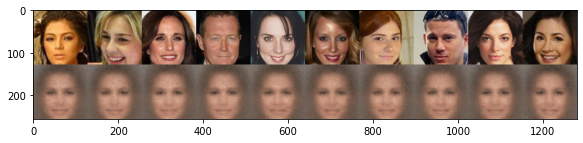

In [ ]:
import matplotlib.pyplot as plt

def compare(model, n_samples = 10):
    file_object = h5py.File('mount/My Drive/Colab Notebooks/firstGAN/celeba_dataset/celeba_aligned_small.h5py', 'r')
    dataset = file_object['img_align_celeba']
    indices = np.random.choice(20000, n_samples)
    x_input_con=None
    for index in indices:
        img = np.array(dataset[str(index)+'.jpg'])
        img = crop_centre(img, 128, 128)
        x_input = torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
        if x_input_con==None:
            x_input_con=x_input
        else:
            x_input_con = torch.concatenate([x_input_con,x_input])
        print(x_input_con.shape)
    y_pre = model.forward(x_input_con).detach().cpu().numpy()
    y_samples = y_pre.reshape(-1,3,128, 128).transpose((2, 0, 3,1)).reshape(128, 128 * n_samples,3)
    x_samples = x_input_con.detach().cpu().numpy().reshape(-1,3, 128, 128).transpose((2, 0, 3,1)).reshape(128, 128 * n_samples,3)

    plt.figure(figsize=(16, 2))
    plt.imshow(np.concatenate([x_samples, y_samples]))

compare(model, 10)